# Project Part 1

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/brearenee/NLP-Project/blob/main/startrek.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/https://github.com/brearenee/NLP-Project/blob/main/startrek.ipynb)


## 1. Introduction/Background
In this notebook, I will analyze a dataset containing dialogue transcripts from various Star Trek series episodes, sourced from Kaggle [here](http://http://https://www.kaggle.com/datasets/birkoruzicka/startrekdialoguetranscripts/data). This dataset encompasses numerous script lines, each accompanied by details regarding the associated episode, series, and the character delivering the dialogue.

The primary objective of this project is to develop a model proficient in predicting the character (denoted as the "y" value) associated with a given line (the "x" value) from the Star Trek series "The Next Generation." This task falls within the domain of Authorship Attribution, a specialized aspect of text classification. It involves the model learning distinctive patterns indicative of the speaking style of each character.

Although this type of prediction can be challenging, the diversity in the personalities and speaking styles of Star Trek characters, particularly in "The Next Generation," gives me hope for a solid analysis. Given the array of characters in Star Trek TNG, the model's predictive task involves a multi-classification scenario. For simplicity, the focus will be narrowed down to the top 8 characters in the show.




## 2. Data Preprocessing/ Exploratory Data Analysis

This phase focuses on examining the data, making necessary adjustments for cleaning the dataset, and ensuring it adopts a format suitable for future analysis. It establishes a continuous loop between Exploratory Data Analysis and Data Preprocessing.

To begin, the dataset originates as a complex, nested JSON file, and its original structure is not optimal for the intended model. You can view the original JSON file [here](http://https://raw.githubusercontent.com/brearenee/NLP-Project/main/dataset/StarTrekDialogue_v2.json) (it’s size is too large for the notebook)

The dataset also contains extra data that isn't relevant to the analysis. Because of this, there's a need to parse through the file, transforming its structure to generate a more streamlined and practical dataframe. Given the objective of predicting lines exclusively from "The Next Generation," data from other series will be removed to refine the dataset.



In [1]:
import pandas as pd
import json
import requests
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
url = 'https://raw.githubusercontent.com/brearenee/NLP-Project/main/dataset/StarTrekDialogue_v2.json'
response = requests.get(url)

##This CodeBlock is thanks to ChatGPT :-) 
if response.status_code == 200:
    json_data = json.loads(response.text)
    lines = []
    characters = []
    episodes = []
  
    # extract the information from the JSON file for the "TNG" series
    for series_name, series_data in json_data.items():
        if series_name == "TNG": 
            for episode_name, episode_data in series_data.items():
                for character_name, character_lines in episode_data.items():
                    for line_text in character_lines:
                        lines.append(line_text)
                        characters.append(character_name)
                        episodes.append(episode_name)
                     
    # Create a DataFrame from the extracted data
    df = pd.DataFrame({
        'Line': lines,
        'Character': characters,
        'Episode': episodes,
    })

    # Remove duplicate lines, keeping the first occurrence (preserving the original order)
    df = df.drop_duplicates(subset='Line', keep='first')

    # Reset the index of the DataFrame
    df.reset_index(drop=True, inplace=True)

else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")


Now that our JSON file is parsed, lets take a look at our dataframe. 

In [3]:
df.head(100)

,Line,Character,Episode
0,"You will agree, Data, that Starfleet's\r order...",PICARD,tng_000
1,As simple as that.,PICARD,tng_000
2,"It's hardly simple, Data, to negotiate a frien...",PICARD,tng_000
3,"Data, how can you be programmed as a virtual e...",PICARD,tng_000
4,"It means to spy, to sneak.",PICARD,tng_000
...,...,...,...
95,My crew and I need a bit more information\r be...,PICARD,tng_000
96,"Good, since we admire what we've seen of your ...",PICARD,tng_000
97,Counsellor? What is it?,PICARD,tng_000
98,Yes. No secrets here if we're to be all to be ...,PICARD,tng_000


Lets now explore the Characters field to see what characters exist in our dataframe. 

In [4]:
unique_characters = df['Character'].unique().tolist()

# Display the list of unique characters
print(unique_characters)

['PICARD', 'DATA', 'TROI', 'TORRES', 'WORF', 'Q', 'TASHA', "O'BRIEN", 'BAILIFF', 'SOLDIER', 'ZORN', 'RIKER', 'WESLEY', 'CRUSHER', 'LAFORGE', 'MCCOY', 'ENSIGN', 'COMPUTER', 'SECURITY', 'CREW', 'WOMAN', 'MAN', 'SHIMODA', 'MACDOUGAL', 'CREWMAN', 'LUTAN', 'HAGON', 'YAREENA', 'CHIEF', 'TARR', 'LETEK', 'MORDOC', 'KAYRON', 'PORTAL', 'KOSINSKI', 'ARGYLE', 'TRAVELLER', 'MAMAN', 'SELAY', 'GEORDI', 'ANTICAN', 'SINGH', 'RIVAN', 'LIATOR', 'EDO', 'BOY', 'GIRL', 'OFFICER', 'MEDIATOR 2', 'MEDIATOR', 'BEVERLY', 'MEDIC', 'BOK', 'KAZAGO', 'RATA', 'VOICES', 'VOICE', 'FACE', 'STEVEN', 'VICTORIA', 'WYATT', 'LWAXANA', 'VALEDA', 'WRENN', 'ARIANA', 'HOMN', 'SECRETARY', 'JESSICA', 'LEECH', 'WHALEN', 'VENDOR', 'BELL', 'MCNARY', 'JARADAN', 'POLICEMAN', 'SERGEANT', 'REDBLOCK', 'THUG', 'LORE', 'BEATA', 'ARIEL', 'TRENT', 'RAMSEY', 'QUINTEROS', 'ONE ZERO', 'ZERO ONE', 'ZERO ZERO', 'ONE ONE', 'MINUET', 'BASS', 'PIANO', 'STARBASE', 'JAMESON', 'KARNAS', 'ANNE', 'BERNARD', 'HARRY', 'RASHELLA', 'RADUE', 'KATIE', 'TOYA', '

As you can see, "The Next Generation" series has quite a few characters. Let's eliminate all of the outliers by removing characters that don't occur in more than 5 episodes. 

In [5]:
episode_counts = df.groupby('Character')['Episode'].nunique()

characters_to_keep = episode_counts[episode_counts > 5].index

df = df[df['Character'].isin(characters_to_keep)]
unique_characters = df['Character'].unique().tolist()


print(unique_characters)

['PICARD', 'DATA', 'TROI', 'WORF', 'Q', 'TASHA', "O'BRIEN", 'RIKER', 'WESLEY', 'CRUSHER', 'LAFORGE', 'COMPUTER', 'SECURITY', 'WOMAN', 'MAN', 'CREWMAN', 'CHIEF', 'MEDIC', 'VOICE', 'LWAXANA', 'CREWWOMAN', 'NURSE', 'GUINAN', 'PULASKI', 'ALL', 'OGAWA', 'KLINGON', 'ROMULAN', 'ALEXANDER', 'KEIKO', 'RO']


This result is a lot better, but there are still some fields in here like "ALL" "BOTH" or "GIRL" that dont correlate to one single character/species 

Lets check the character distribution


In [6]:
df['Character'].value_counts()


Character
PICARD       10798
RIKER         6454
DATA          5699
LAFORGE       4111
WORF          3185
CRUSHER       2944
TROI          2856
WESLEY        1206
Q              535
PULASKI        487
TASHA          474
COMPUTER       471
O'BRIEN        440
GUINAN         432
LWAXANA        404
RO             304
ALEXANDER      156
OGAWA          110
KEIKO           78
CREWMAN         51
WOMAN           46
NURSE           30
CHIEF           28
VOICE           27
ROMULAN         25
MAN             22
CREWWOMAN       17
SECURITY        15
KLINGON         14
ALL             13
MEDIC            6
Name: count, dtype: int64

The chart provides a clear depiction of the number of lines attributed to each character in our dataset. Given the imbalance in this distribution, our next step involves addressing this by once again removing outliers.

To achieve this, characters with fewer than 1000 lines will be removed. This allows us to retain characters that frequently appear, ensuring a substantial volume of lines for our model to gain insights and patterns from.


In [7]:
character_counts = df['Character'].value_counts()

characters_to_remove = character_counts[character_counts < 1000].index
df = df[~df['Character'].isin(characters_to_remove)]


Lets take another look at our Character distribution now that we have removed the outliers

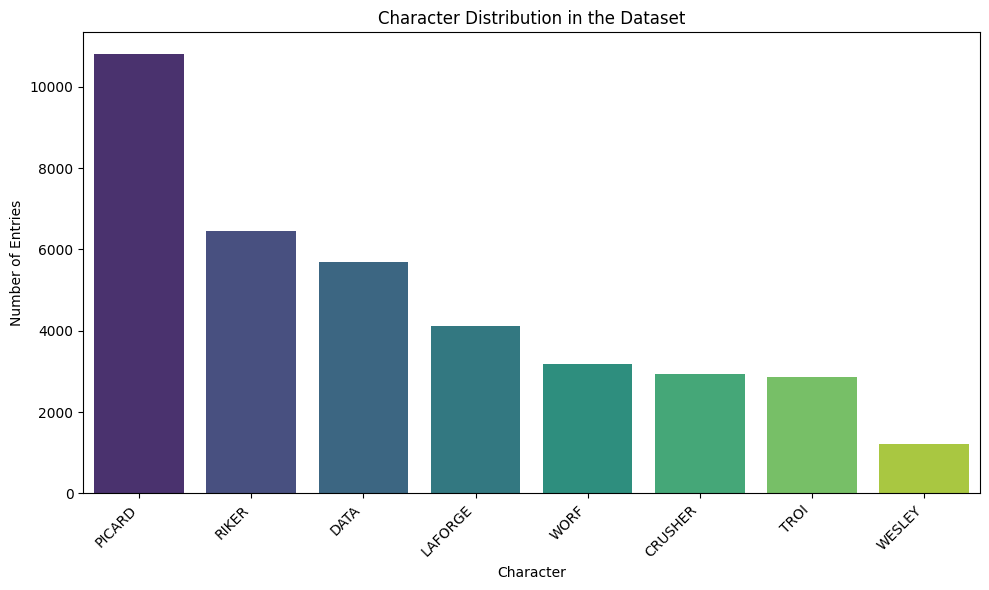

In [8]:
character_counts = df['Character'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=character_counts.index, y=character_counts.values, palette="viridis")
plt.xlabel('Character')
plt.ylabel('Number of Entries')
plt.title('Character Distribution in the Dataset')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [9]:
print(character_counts)

Character
PICARD     10798
RIKER       6454
DATA        5699
LAFORGE     4111
WORF        3185
CRUSHER     2944
TROI        2856
WESLEY      1206
Name: count, dtype: int64


## Tokenizing 
Before exploring our observations (lines), we'll initiate the tokenization process for the "Lines" field in our dataframe. This involves breaking down each sentence into individual tokens, enhancing the model's ability to interpret and analyze them.

For the current phase, we're retaining stop words. There’s a chance they might hold stylistic nuances that are important for character prediction.  However, recognizing that our dataset is sourced from the internet, we'll enforce consistency by converting all text in the "Line" field to lowercase.


In [10]:
nltk.download('punkt')
df['Line'] = df['Line'].apply(lambda x: word_tokenize(x.lower()))


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Lets print out the words/tokens that show up most. 

In [11]:
all_tokens = [token for sublist in df['Line'] for token in sublist]

word_frequencies = pd.DataFrame({
    'Token': all_tokens
})

top_words = word_frequencies['Token'].value_counts().head(20)

print("Top 20 Tokens:")
top_words


Top 20 Tokens:


Token
.       52781
,       25925
the     19638
to      15146
i       14973
you     12713
?        9671
a        9294
it       8228
of       7937
is       7069
that     6707
we       6562
's       6159
and      5186
in       4767
have     4663
this     3921
be       3784
do       3759
Name: count, dtype: int64

Upon inspection, you can see there’s a large presence of punctuation in our text. While these tokens are likely unhelpful, there’s a chance tokens like commas or question marks could contribute to speaking styles, enhancing character prediction in our models.  Because of this, punctuation will be retained in our dataset (for the time being).

What's the vocabulary size? 

In [12]:
vocabulary_size = len(set(word for tokens in df['Line'] for word in tokens))

print("Vocabulary Size:", vocabulary_size)

Vocabulary Size: 16123


Lets add a "Line Length" to a our dataframe, and print out a chart showing average line length per character. 

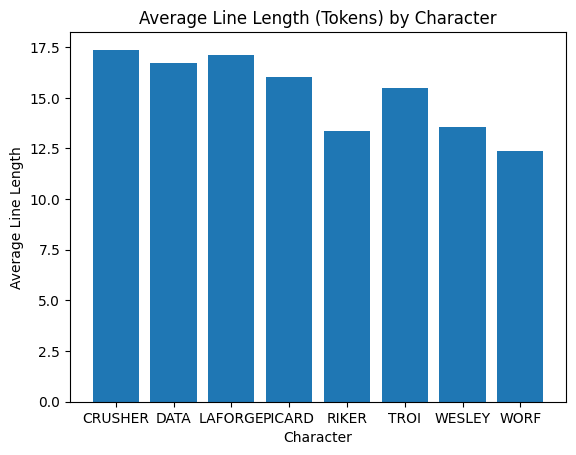

In [13]:

df['Line Length'] = df['Line'].apply(len)
avg_line_length_by_character = df.groupby('Character')['Line Length'].mean().reset_index()


plt.bar(avg_line_length_by_character['Character'], avg_line_length_by_character['Line Length'])
plt.xlabel('Character')
plt.ylabel('Average Line Length')
plt.title('Average Line Length (Tokens) by Character')
plt.show()

I was surprised to see that overall, the average line length is consistent across the board.  Lets look at distribution of line length in general, where length is the number of tokens in a line. 

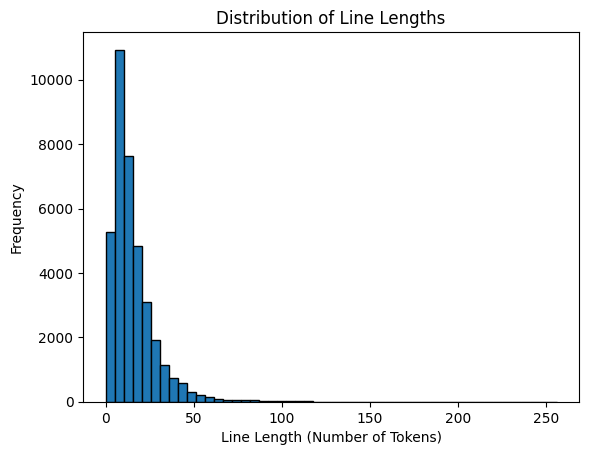

In [14]:
plt.hist(df['Line Length'], bins=50, edgecolor='black')
plt.xlabel('Line Length (Number of Tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Line Lengths')
plt.show()

For the most part, the length of each line is around 20 tokens. But lets see the outliers by filtering for lines over 200 tokens

In [15]:
long_lines_df = df[df['Line Length'] > 175]

long_lines_df[['Character','Line Length']]

,Character,Line Length
12012,PICARD,236
27648,WESLEY,184
31991,CRUSHER,256
55976,PICARD,201


Looks like Picard is the most common one giving speeches, but Dr Crusher and her son Wesley also give a speech at some point during the series. 

One last look at our dataframe with the tokenized lines and Line Length

In [16]:
df.head(10)

,Line,Character,Episode,Line Length
0,"[you, will, agree, ,, data, ,, that, starfleet...",PICARD,tng_000,12
1,"[as, simple, as, that, .]",PICARD,tng_000,5
2,"[it, 's, hardly, simple, ,, data, ,, to, negot...",PICARD,tng_000,36
3,"[data, ,, how, can, you, be, programmed, as, a...",PICARD,tng_000,22
4,"[it, means, to, spy, ,, to, sneak, .]",PICARD,tng_000,8
5,"[exactly, ,, yes, .]",PICARD,tng_000,4
6,"[shut, off, that, damned, noise, ., go, to, ye...",PICARD,tng_000,11
7,"[reverse, power, ,, full, stop, .]",PICARD,tng_000,6
8,"[that, 's, quite, a, directive, ., would, you,...",PICARD,tng_000,14
9,"[data, ,, call, medics, .]",PICARD,tng_000,5
